In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 100)

In [73]:
data = pd.read_csv('train.csv')
train_orig, test = train_test_split(data, test_size=0.2)
train_orig.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1168.000000,1168.000000,1168,963.000000,1168.000000,1168,69,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168.000000,1168.000000,1168.000000,1168.000000,1168,1168,1168,1168,1162,1162.000000,1168,1168,1168,1140,1140,1139,1140,1168.000000,1139,1168.000000,1168.000000,1168.000000,1168,1168,1168,1168,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168,1168.000000,1168,1168.000000,613,1104,1104.000000,1104,1168.000000,1168.000000,1104,1104,1168,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,7,228,40,1168.000000,1168.000000,1168.000000,1168,1168,1168.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,7,5,8,NaN,NaN,NaN,NaN,6,6,14,16,4,NaN,4,5,6,4,3,4,6,NaN,6,NaN,NaN,NaN,5,5,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,6,NaN,5,6,NaN,3,NaN,NaN,4,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,924,NaN,NaN,1163,39,727,1052,1167,838,1103,175,1021,1157,977,592,NaN,NaN,NaN,NaN,914,1147,420,412,685,NaN,717,1036,524,529,1056,762,339,NaN,1011,NaN,NaN,NaN,1145,584,1092,1071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,586,NaN,1090,NaN,305,699,NaN,482,NaN,NaN,1051,1062,1074,NaN,NaN,NaN,NaN,NaN,NaN,3,129,36,NaN,NaN,NaN,1015,954,NaN
mean,732.899829,56.446918,NaN,70.499481,10393.190925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.113014,5.585616,1971.651541,1985.228596,NaN,NaN,NaN,NaN,NaN,104.412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,452.943493,NaN,45.103596,567.139555,1065.186644,NaN,NaN,NaN,NaN,1166.983733,336.452055,5.015411,1508.451199,0.434932,0.057363,1.559075,0.382705,2.855308,1.046233,NaN,6.517123,NaN,0.606164,NaN,NaN,1978.789855,NaN,1.782534,477.089897,NaN,NaN,NaN,95.178082,47.438356,21.472603,2.026541,14.908390,3.448630,NaN,NaN,NaN,35.645548,6.296233,2007.826199,NaN,NaN,181188.791096
std,423.160945,41.978743,NaN,24.827947,9390.911403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.391331,1.089578,30.216374,20.536213,NaN,NaN,NaN,NaN,NaN,179.974693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466.988689,NaN,158.054530,448.471373,442.947318,NaN,NaN,NaN,NaN,387.177901,430.219365,44.619631,519.863929,0.517934,0.239888,0.546018,0.501865,0.797676,0.221979,NaN,1.605383,NaN,0.640557,NaN,NaN,24.472777,NaN,0.757009,217.357909,NaN,NaN,NaN,125.976198,67.525574,60.104045,19.405787,56.035865,44.896939,NaN,NaN,NaN,482.148371,2.718672,1.334314,NaN,NaN,79143.205260
min,3.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,372.000000,0.000000,0.000000,438.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,3.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.000

In [74]:
def preprocess(df):
    keep_columns = ['Id', 'BedroomAbvGr', 'FullBath', 'HalfBath', 'GrLivArea',
            'MSZoning', 'Neighborhood', 'Condition1',
            'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
            'ExterQual', 'ExterCond', 'BsmtQual',
            'HeatingQC', 'CentralAir', 'KitchenQual',
            'Fireplaces', 'GarageCars', 'YrSold',]
    if 'SalePrice' in df.columns: keep_columns += ['SalePrice']
    df = df.copy()
    df = df[keep_columns]
    df['GrLivArea'] = df['GrLivArea'].astype(np.float64)
    
    df['BedroomAbvGr'] = pd.cut(df['BedroomAbvGr'], [0, 1, 2, 3, 10], right=True)
    df['Bath'] = df['FullBath'] + df['HalfBath']
    del df['FullBath']
    del df['HalfBath']
    df['Bath'] = pd.cut(df['Bath'], [-1, 1, 2, 10], right=True)
    df.loc[-df['MSZoning'].isin(['RL', 'RM']), 'MSZoning'] = 'Other'
    df.loc[-df['Neighborhood'].isin(['NAmes', 'CollgCr', 'OldTown', 'Edwards',
                                      'Somerst', 'Gilbert', 'NridgHt', 'NWAmes',
                                      'Sawyer', 'BrkSide']), 'Neighborhood'] = 'Other'
    df['Condition1'] = df['Condition1'].replace(['Norm', 'PosN', 'PosA',], 'Norm/Pos')
    df['Condition1'] = df['Condition1'].replace(['Feedr', 'Artery', 'RRAn', 'RRAe',
                                                'RRNn', 'RRNe',], 'Road/RR')
    df['BldgType'] = df['BldgType'].replace(['2fmCon', 'Duplex',], '2Fam')
    df['BldgType'] = df['BldgType'].replace(['TwnhsE', 'TwnhsI',], 'Twnhs')
    df['HouseStyle'] = df['HouseStyle'].replace('1.5Unf', '1Story')
    df['HouseStyle'] = df['HouseStyle'].replace(['2.5Unf', '2.5Fin'], '2Story')
    df['HouseStyle'] = df['HouseStyle'].replace('SFoyer', 'SLvl')
    df['OverallQual_cat'] = pd.cut(df['OverallQual'], [0, 4, 5, 6, 7, 10], right=True)
    del df['OverallQual']
    df['OverallCond_cat'] = pd.cut(df['OverallCond'], [0, 4, 5, 6, 7, 10], right=True)
    del df['OverallCond']
    df['YearBuilt_cat'] = pd.cut(df['YearBuilt'], [1800, 1929, 1949, 1959, 1969, 1979,
                                                   1995, 2000, 2005, 2015], right=True)
    del df['YearBuilt']
    df['ExterQual'] = df['ExterQual'].replace(['Po', 'Fa', 'TA'], 'Po/Fa/TA')
    df['ExterCond'] = df['ExterCond'].replace(['Po', 'Fa', 'TA'], 'Po/Fa/TA')
    df['ExterCond'] = df['ExterCond'].replace(['Gd', 'Ex'], 'Gd/Ex')
    df['BsmtQual'] = df['BsmtQual'].replace(['Po', 'Fa', 'TA'], 'Po/Fa/TA')
    df['BsmtQual'] = df['BsmtQual'].replace(np.nan, 'NA')
    df['HeatingQC'] = df['HeatingQC'].replace(['Po', 'Fa'], 'Po/Fa')
    df['KitchenQual'] = df['KitchenQual'].replace(['Po', 'Fa', 'TA'], 'Po/Fa/TA')
    df['Fireplace'] = (df['Fireplaces'] > 0).astype(np.uint8)
    del df['Fireplaces']
    df.loc[df['GarageCars'] > 3, 'GarageCars'] = 3
    assert not (df['YrSold'] < 2006).any()
    assert not (df['YrSold'] > 2010).any()
    
    dummies = [('BedroomAbvGr', 4), ('Bath', 3), 
               ('MSZoning', 3), ('Neighborhood', 11),
              ('Condition1', 2), ('BldgType', 3), ('HouseStyle', 4), ('OverallQual_cat', 5),
              ('OverallCond_cat', 5), ('YearBuilt_cat', 9), ('ExterQual', 3),
              ('ExterCond', 2), ('BsmtQual', 4), ('HeatingQC', 4),
               ('CentralAir', 2), ('KitchenQual', 3),
               ('GarageCars', 4), ('YrSold', 5),]
    for dummy, num_values in dummies:
        assert len(df[dummy].value_counts()) == num_values
        df = pd.concat([df, pd.get_dummies(df[dummy], prefix=dummy)], axis=1)
        del df[dummy]
    
    return df
train = preprocess(train_orig)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 457 to 862
Data columns (total 80 columns):
Id                            1168 non-null int64
GrLivArea                     1168 non-null float64
SalePrice                     1168 non-null int64
Fireplace                     1168 non-null uint8
BedroomAbvGr_(0, 1]           1168 non-null uint8
BedroomAbvGr_(1, 2]           1168 non-null uint8
BedroomAbvGr_(2, 3]           1168 non-null uint8
BedroomAbvGr_(3, 10]          1168 non-null uint8
Bath_(-1, 1]                  1168 non-null uint8
Bath_(1, 2]                   1168 non-null uint8
Bath_(2, 10]                  1168 non-null uint8
MSZoning_Other                1168 non-null uint8
MSZoning_RL                   1168 non-null uint8
MSZoning_RM                   1168 non-null uint8
Neighborhood_BrkSide          1168 non-null uint8
Neighborhood_CollgCr          1168 non-null uint8
Neighborhood_Edwards          1168 non-null uint8
Neighborhood_Gilbert          1168 non-n

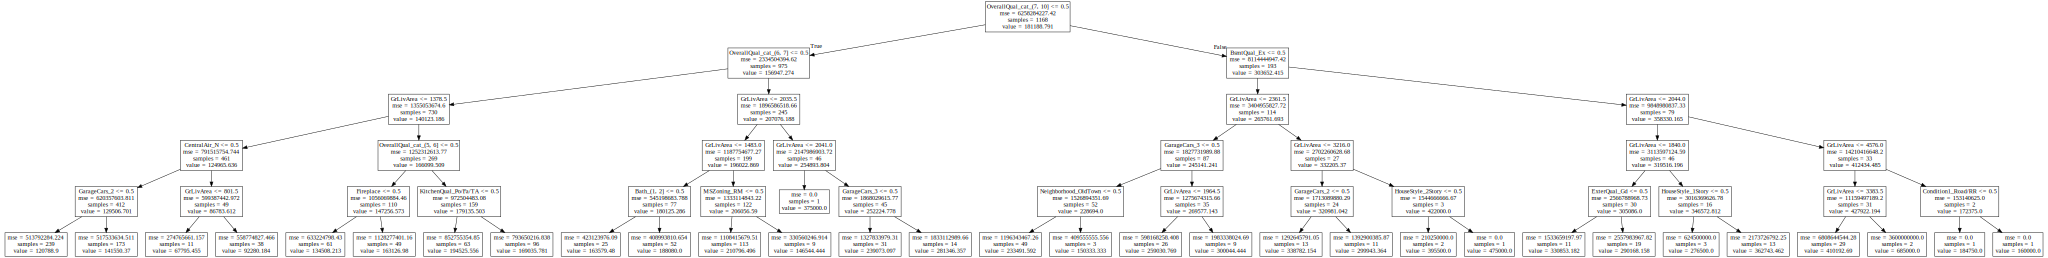

In [75]:
feature_names = list(train.drop(['Id', 'SalePrice'], axis=1).columns)

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if 'SalePrice' in X.columns:
            return X.drop(['SalePrice', 'Id'], axis=1).values
        else:
            return X.drop('Id', axis=1).values

dtree_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('dtree', DecisionTreeRegressor(max_depth=5)),
])
dtree_pipe.fit(train, train['SalePrice'])
dot_data = export_graphviz(dtree_pipe.named_steps['dtree'], out_file=None,
                           feature_names=feature_names)
graphviz.Source(dot_data)

In [76]:
etree_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('etree', ExtraTreesRegressor())
])
etree_pipe.fit(train, train['SalePrice'])
importances = etree_pipe.named_steps['etree'].feature_importances_
print('Mean feature importance: {0:>20.4f}'.format(np.mean(importances)))
print('Median feature importance: {0:>18.4f}'.format(np.median(importances)))
print('{0:30} {1:10}'.format('Feature', 'Importance'))
printlnmean = True
printlnmedian = True
for i, importance in sorted(enumerate(importances), key=lambda x: -x[1]):
    if importance < np.mean(importances) and printlnmean:
        print('-'*80)
        printlnmean = False
    if importance < np.median(importances) and printlnmedian:
        print('-'*80)
        printlnmedian = False
    print('{0:30} {1:10.4f}'.format(feature_names[i], importance))
model = SelectFromModel(etree_pipe.named_steps['etree'], prefit=True, threshold='median')
X_new = model.transform(train.drop(['Id', 'SalePrice'], axis=1))
X_new.shape

Mean feature importance:               0.0128
Median feature importance:             0.0026
Feature                        Importance
OverallQual_cat_(7, 10]            0.4744
OverallQual_cat_(6, 7]             0.1125
GrLivArea                          0.0864
BsmtQual_Ex                        0.0555
OverallQual_cat_(5, 6]             0.0299
BedroomAbvGr_(3, 10]               0.0159
GarageCars_3                       0.0159
GarageCars_2                       0.0146
--------------------------------------------------------------------------------
Fireplace                          0.0091
YearBuilt_cat_(1995, 2000]         0.0089
Bath_(-1, 1]                       0.0075
MSZoning_RM                        0.0072
BedroomAbvGr_(2, 3]                0.0070
YrSold_2010                        0.0059
OverallQual_cat_(4, 5]             0.0056
Neighborhood_Other                 0.0055
YrSold_2009                        0.0054
KitchenQual_Po/Fa/TA               0.0053
Neighborhood_Edwards         

(1168, 39)

In [77]:
class ContinuousScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        global feature_names
        self.continuous_col = feature_names.index('GrLivArea')
        
    def fit(self, X, y=None):
        self.scaler.fit(X[:, self.continuous_col].reshape(-1, 1))
        return self
    
    def transform(self, X):
        return np.c_[np.delete(X, self.continuous_col, axis=1),
                    self.scaler.transform(X[:, self.continuous_col].reshape(-1, 1))]

scale_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('scaler', ContinuousScaler()),
])
scale_pipe.fit(train)
train_scaled = scale_pipe.transform(train)
print(train.drop(['Id', 'SalePrice'], axis=1).iloc[:5, range(-9, 0+1)])
print(train_scaled[:5, -10:])
print(train_scaled.shape)

      GarageCars_0  GarageCars_1  GarageCars_2  GarageCars_3  YrSold_2006  \
457              0             0             1             0            0   
949              0             0             1             0            0   
1265             0             0             1             0            1   
1207             0             0             1             0            1   
407              0             1             0             0            0   

      YrSold_2007  YrSold_2008  YrSold_2009  YrSold_2010  GrLivArea  
457             0            1            0            0     1663.0  
949             0            0            0            1     1381.0  
1265            0            0            0            0     1452.0  
1207            0            0            0            0     1700.0  
407             0            1            0            0     1680.0  
[[ 0.          0.          1.          0.          0.          0.          1.
   0.          0.          0.29741437]


In [78]:
analysis_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('scaler', ContinuousScaler()),
    ('feature_select', SelectFromModel(ExtraTreesRegressor())),
    ('model', DecisionTreeRegressor(max_depth=5)),
])

param_grid = [{
    'feature_select__threshold': ['mean', 'median',],
    'model': [DecisionTreeRegressor(max_depth=i, random_state=0) for i in range(3, 7+1)] +
        [RandomForestRegressor(max_depth=i, random_state=0) for i in range(3, 7+1)] +
        [Ridge(alpha, random_state = 0) for alpha in np.logspace(-10, -2, 5)] +
        [KNeighborsRegressor(n_neighbors = n, weights=w)
            for n in (3, 5, 7) for w in ('uniform', 'distance')] +
        [LinearSVR(C=c, epsilon=0, random_state=0) for c in [0.1, 1, 10]] +
        [SVR(C=c, gamma='auto', kernel='rbf', epsilon=0) for c in [0.1, 1, 10]]
}]

grid_search = GridSearchCV(analysis_pipe, param_grid, scoring='neg_mean_squared_log_error',)
grid_search.fit(train, train['SalePrice'])
print('Best parameters:', grid_search.best_params_)
print('Best RMSLE:', np.sqrt(-grid_search.best_score_))

Best parameters: {'feature_select__threshold': 'median', 'model': Ridge(alpha=9.9999999999999995e-07, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=0, solver='auto',
   tol=0.001)}
Best RMSLE: 0.17123805805


In [79]:
analysis_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('scaler', ContinuousScaler()),
    ('feature_select', SelectFromModel(ExtraTreesRegressor(), threshold='median')),
    ('ridge', Ridge(alpha=10e-07, random_state=0)),
])

param_grid = {
    'feature_select': [SelectFromModel(ExtraTreesRegressor(), threshold='median'), None],
    'ridge__alpha': np.logspace(-10, 10, 100),
}

grid_search = GridSearchCV(analysis_pipe, param_grid, scoring='neg_mean_squared_log_error')
grid_search.fit(train, train['SalePrice'])
print('Best parameters:', grid_search.best_params_)
print('Best RMSLE:', np.sqrt(-grid_search.best_score_))

Best parameters: {'feature_select': None, 'ridge__alpha': 20.565123083486515}
Best RMSLE: 0.156249602416


In [80]:
test = preprocess(pd.read_csv('test.csv'))
test['SalePrice'] = grid_search.best_estimator_.predict(test)
test = test[['Id', 'SalePrice']]
print(test.head())
test.to_csv('submission.csv', index=False)

     Id      SalePrice
0  1461  106535.999942
1  1462  153274.295869
2  1463  175083.964509
3  1464  188291.083616
4  1465  205681.451988
